# The Evolution of Altruistic Behavior

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import imageio
import os
import shutil
import random

In [5]:
class Altruism_model:
    
    def __init__(self, altruist_pop=0.4, egoist_pop=0.4, cost_of_altruism=0.9, benefit_from_altruism=0.9, harshness=0.5, disease=0.5):
        self.altruist_pop = altruist_pop
        self.egoist_pop = egoist_pop
        self.grid_width = 50
        self.grid_length = 50
        self.cost_of_altruism = cost_of_altruism
        self.benefit_from_altruism = benefit_from_altruism
        self.harshness = harshness
        self.disease = disease
        self.n_altruist = round(self.altruist_pop * self.grid_length * self.grid_width)
        self.n_egoist = round(self.egoist_pop * self.grid_length * self.grid_width)
        self.n_empty = self.grid_length * self.grid_width - self.n_altruist - self.n_egoist
        self.board = np.random.choice([0]*self.n_empty + [1]*self.n_altruist + [2]*self.n_egoist, replace=False, size=self.grid_length * self.grid_width)
        self.board = np.reshape(self.board, (self.grid_length, self.grid_width))

        self.previous_step = np.full(self.board.shape, None)
        self.end = False
        
        
    def one_step(self): 
                
        if (~np.all(self.board == self.previous_step)):
            self.previous_step = self.board.copy()
            
            #self.pos = np.argwhere(self.board != -1)  # gets locations of non-empty cells
            #self.shuffled = random.sample(self.pos.tolist(), len(self.pos))  #shuffles the list of locations
            self.fitness_matrix = np.zeros((self.grid_length, self.grid_width))
            
            for i in range(self.grid_length):
                for j in range(self.grid_width):
                    loc_x = list(range(i-1, i+1+1))  # neighbors localization based on a depth of a neighborhood
                    loc_x = [loc - self.grid_length if loc >= self.grid_length else loc for loc in loc_x]  # periodic boubdary condition
                    loc_x = [self.grid_length + loc if loc < 0 else loc for loc in loc_x]
                    loc_y = list(range(j-1, j+1+1))
                    loc_y = [loc - self.grid_width if loc >= self.grid_width else loc for loc in loc_y]
                    loc_y = [self.grid_width + loc if loc < 0 else loc for loc in loc_y]
                    self.me = self.board[i,j] 
                    #print(self.me)
                    self.neighbors = [self.board[i,loc_y[0]], self.board[i,loc_y[2]], self.board[loc_x[0],j], self.board[loc_x[2],j]]  # matrix of my neighbors plus me in the middle
                    self.neighbors.append(self.me)  # my neighbors and me
                    #print(self.neighbors)
                    self.altruist_neighbors = self.neighbors.count(1)
                    #print(self.altruist_neighbors)

                    if self.me == 2:  #egoist
                        self.fitness_matrix[i,j] = 1 + self.altruist_neighbors/5 * self.benefit_from_altruism
                    if self.me == 1:  #altruist
                        self.fitness_matrix[i,j] = 1 - self.cost_of_altruism + self.altruist_neighbors/5 * self.benefit_from_altruism
                    if self.me == 0:  #empty
                        self.fitness_matrix[i,j] = self.harshness
            
            for i in range(self.grid_length):
                for j in range(self.grid_width):
                    loc_x = list(range(i-1, i+1+1))  # neighbors localization based on a depth of a neighborhood
                    loc_x = [loc - self.grid_length if loc >= self.grid_length else loc for loc in loc_x]  # periodic boubdary condition
                    loc_x = [self.grid_length + loc if loc < 0 else loc for loc in loc_x]
                    loc_y = list(range(j-1, j+1+1))
                    loc_y = [loc - self.grid_width if loc >= self.grid_width else loc for loc in loc_y]
                    loc_y = [self.grid_width + loc if loc < 0 else loc for loc in loc_y]
                    self.me = self.previous_step[i,j] 
                    self.neighbors = [self.previous_step[i,loc_y[0]], self.previous_step[i,loc_y[2]], 
                                      self.previous_step[loc_x[0],j], self.previous_step[loc_x[2],j]]  # matrix of my neighbors plus me in the middle
                    self.neighbors.append(self.me)  # my neighbors and me
                    self.neighbors_fitness = [self.fitness_matrix[i,loc_y[0]], self.fitness_matrix[i,loc_y[2]], 
                                              self.fitness_matrix[loc_x[0],j], self.fitness_matrix[loc_x[2],j]]
                    self.neighbors_fitness.append(self.fitness_matrix[i,j])   # fitnesses of my neighbors and me
                    
                    self.altruist_weight = sum(np.array(self.neighbors_fitness)[np.where(np.array(self.neighbors) == 1)[0]])
                    self.egoist_weight = sum(np.array(self.neighbors_fitness)[np.where(np.array(self.neighbors) == 2)[0]])
                    self.empty_weight = sum(np.array(self.neighbors_fitness)[np.where(np.array(self.neighbors) == 0)[0]])
                    self.sum_weights = self.altruist_weight + self.egoist_weight + self.empty_weight + self.disease
                    
                    if any(self.neighbors) != 0:
                        #self.board[i,j] = 1 if random.random()*(self.altruist_weight+self.egoist_weight) < self.altruist_weight else 2
                        lottery = random.random() * self.sum_weights
                        if lottery < self.altruist_weight:
                            self.board[i,j] = 1
                        elif lottery < self.altruist_weight + self.egoist_weight:
                            self.board[i,j] = 2
                        else:
                            self.board[i,j] = 0
        else:
            self.end = True   

   

In [32]:
def animate(altruist_pop=0.4, egoist_pop=0.4, cost_of_altruism=0.9, benefit_from_altruism=0.9, harshness=0.5, disease=0.5):
    gif_path = "alt_pop_{apop}_eg_pop_{epop}_cost_{cost}_benefit_{ben}_harsh_{h}_dis_{d}_simulation.gif".format(apop=altruist_pop, epop=egoist_pop, cost=cost_of_altruism, ben=benefit_from_altruism, h=harshness, d=disease)
    folder_path = "frames"
    
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
    os.makedirs(folder_path)
    
    frames_path = folder_path + "/{i}.jpg"
    
    cmap = colors.ListedColormap(['k','#FFBF46','#575761'])

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.grid()
    ax.set_title('Altruist population {apop}, egoist population {epop}, cost of altruism {cost}, benefit from altruism {ben},\nharshness {h}, disease {d}'.format(apop=altruist_pop, epop=egoist_pop, cost=cost_of_altruism, ben=benefit_from_altruism, h=harshness, d=disease))

    initial = Altruism_model(altruist_pop, egoist_pop, cost_of_altruism, benefit_from_altruism, harshness, disease)
    im = ax.imshow(initial.board, cmap=cmap)
    plt.savefig("frames/0.jpg")

    n = 1
    while (initial.end == False) & (n<400):
        initial.one_step()
        im.set_array(initial.board)
        plt.savefig(frames_path.format(i=n))
        n += 1

    with imageio.get_writer(gif_path, mode='I') as writer:
        for i in range(n):
            writer.append_data(imageio.imread(frames_path.format(i=i)))


In [33]:
animate(altruist_pop=0.5, egoist_pop=0.2, cost_of_altruism=0.4, harshness=0, disease=0.5)

In [36]:
def make_plot(altruist_pop=0.4, egoist_pop=0.4, cost_of_altruism=0.9, benefit_from_altruism=0.9, harshness=0.5, disease=0.5):
    
    number_altruist = []
    number_egoist = []
    initial = Altruism_model(altruist_pop, egoist_pop, cost_of_altruism, benefit_from_altruism, harshness, disease)
    for i in range(300):
        number_altruist.append(np.count_nonzero(initial.board == 1))
        number_egoist.append(np.count_nonzero(initial.board == 2))
        initial.one_step()
        
    fig, ax = plt.subplots(1,1, figsize=(19, 6))
    plt.grid(alpha=0.3)
    plt.plot(number_altruist, color='#FFBF46')
    plt.plot(number_egoist, color='#575761')
    ax.set_ylim(0, initial.grid_width*initial.grid_length)
    plt.xlabel('Time', size = 16)
    plt.ylabel('Number of agents', size = 16)
    plt.legend(['Altruists', 'Egoists'], loc=1, prop={'size': 15})
    plt.title('Altruist population {apop}, egoist population {epop}, cost of altruism {cost}, benefit from altruism {ben},\nharshness {h}, disease {d}'.format(apop=altruist_pop, epop=egoist_pop, cost=cost_of_altruism, ben=benefit_from_altruism, h=harshness, d=disease),
             size = 18)
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    plt.savefig("alt_pop_{apop}_eg_pop_{epop}_cost_{cost}_benefit_{ben}_harsh_{h}_dis_{d}.svg".format(apop=altruist_pop, epop=egoist_pop, cost=cost_of_altruism, ben=benefit_from_altruism, h=harshness, d=disease))
    plt.show()
    

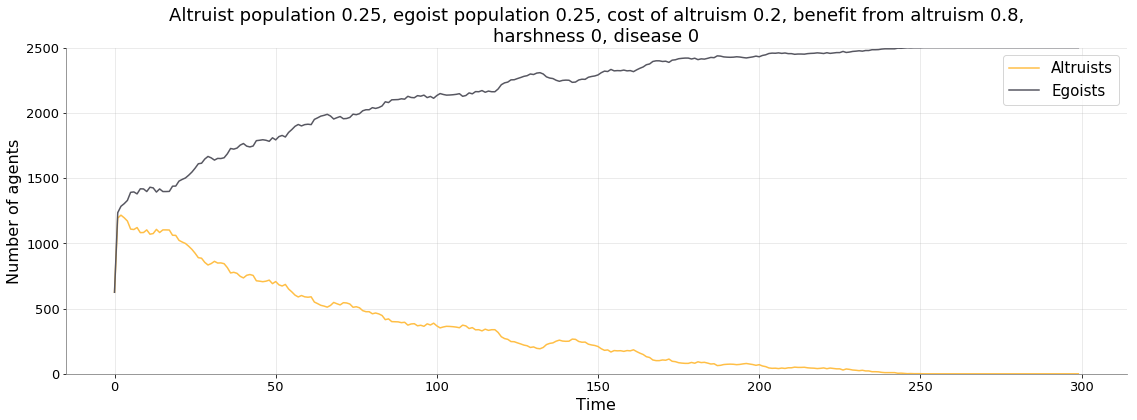

In [37]:
make_plot(altruist_pop=0.25, egoist_pop=0.25, cost_of_altruism=0.2, benefit_from_altruism=0.8, harshness=0, disease=0)